# HW9 — LLM 微調：情緒分類與憂鬱症風險監測

完整流程涵蓋資料前處理、Zero-shot / Few-shot 推論、LoRA (QLoRA) 微調、評估指標與視覺化。

## 專案重點
- Emotion Dataset (dair-ai/emotion) 為基礎，並建立 joy→low 等風險映射
- 實作三種推論策略：Zero-shot、Few-shot、LoRA/QLoRA 微調
- 評估 Emotion 與 Risk 兩個任務（F1、AUROC、PR-AUC、Confusion Matrix）
- 以高風險機率打造走勢圖與 rolling heatmap，示範憂鬱症風險監測
- 透過技術報告區塊整理觀察與後續研究方向

In [1]:
%%capture
!pip install -U datasets transformers accelerate peft bitsandbytes evaluate scikit-learn seaborn

In [2]:
import os
import math
import random
import inspect
from pathlib import Path
from typing import Callable, Dict, List, Optional

import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn.metrics import (accuracy_score, average_precision_score,
                             confusion_matrix, f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from transformers import (AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,
                          DataCollatorForLanguageModeling, Trainer,
                          TrainingArguments)
from peft import LoraConfig, PeftModel, get_peft_model

plt.style.use("seaborn-v0_8")
tqdm.pandas()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


In [3]:
CONFIG = {
    "dataset_name": "dair-ai/emotion",
    "base_model_name": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "seed": 42,
    "max_seq_length": 512,
    "eval_sample_size": 512,
    "few_shot_k": 5,
    "use_4bit": True,
    "bnb_compute_dtype": "bfloat16",
    "trust_remote_code": False,
    "lora_rank": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 4,
    "num_train_epochs": 1,
    "learning_rate": 2e-4,
    "weight_decay": 0.01,
    "warmup_ratio": 0.05,
    "logging_steps": 10,
    "output_dir": "artifacts/tinyllama-emotion-lora",
    "lora_train_size": 4000,
    "max_eval_examples_for_visualization": 2000,
    "rolling_window": 30,
    "rolling_stride": 10,
}

Path(CONFIG["output_dir"]).mkdir(parents=True, exist_ok=True)

In [4]:
GPU_REQUIRED = True
if GPU_REQUIRED and not torch.cuda.is_available():
    raise EnvironmentError("請於 GPU runtime 執行此 Notebook，例如 Colab GPU。")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"Detected GPU: {gpu_name} ({total_mem:.1f} GB)")
    try:
        import subprocess
        print(subprocess.check_output(['nvidia-smi']).decode('utf-8'))
    except Exception as exc:
        print(f"nvidia-smi 無法執行: {exc}")


Detected GPU: Tesla T4 (14.7 GB)
Sun Nov 16 17:25:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------

## Emotion Dataset 與風險映射
依據作業規格，將 joy / love / surprise → 低風險，anger / fear → 中風險，sadness → 高風險。以下載入 HuggingFace Emotion Dataset 並新增對應欄位。

In [5]:
RISK_MAPPING = {
    "joy": 0,
    "love": 0,
    "surprise": 0,
    "anger": 1,
    "fear": 1,
    "sadness": 2,
}
RISK_NAMES = {0: "low_risk", 1: "mid_risk", 2: "high_risk"}

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG["seed"])

raw_dataset = load_dataset(CONFIG["dataset_name"])
EMOTION_LABELS = raw_dataset["train"].features["label"].names
EMOTION2ID = {label: idx for idx, label in enumerate(EMOTION_LABELS)}

def enrich_record(example: Dict) -> Dict:
    emotion = EMOTION_LABELS[example["label"]]
    risk_id = RISK_MAPPING[emotion]
    example["emotion_label"] = emotion
    example["risk_label"] = risk_id
    example["risk_name"] = RISK_NAMES[risk_id]
    return example

dataset = raw_dataset.map(enrich_record)
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'emotion_label', 'risk_label', 'risk_name'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'emotion_label', 'risk_label', 'risk_name'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'emotion_label', 'risk_label', 'risk_name'],
        num_rows: 2000
    })
})

In [6]:
pd.DataFrame(dataset["train"].select(range(5)))

,text,label,emotion_label,risk_label,risk_name
0,i didnt feel humiliated,0,sadness,2,high_risk
1,i can go from feeling so hopeless to so damned...,0,sadness,2,high_risk
2,im grabbing a minute to post i feel greedy wrong,3,anger,1,mid_risk
3,i am ever feeling nostalgic about the fireplac...,2,love,0,low_risk
4,i am feeling grouchy,3,anger,1,mid_risk


## Emotion Dataset 詳解與風險映射說明
- Emotion (dair-ai/emotion) 來自 Saravia et al., 2018，包含 16k/2k/2k 的英文短句，六種情緒標籤平均分布。
- 本研究將原始 `label` 轉為 `emotion_label`，並根據課堂規則新增 `risk_label` / `risk_name`：joy、love、surprise → low_risk；anger、fear → mid_risk；sadness → high_risk。
- 此映射假設正向情緒對憂鬱風險具保護性，憤怒與恐懼屬於潛在壓力訊號，而悲傷則視為高度關聯。
- 下游任務可同時取用 Emotion 與 Risk 兩個標的，zero/few-shot prompt 也沿用同一規則以確保一致性。


## 公用函式：Prompt、打分與指標
建立 prompt 模板、Few-shot builder、LoRA tokenization 與評估工具，方便後續重複使用。

In [7]:
SYSTEM_PROMPT = (
    "You are a bilingual mental-health assistant that labels emotions and estimates \n    depression risk levels from short social posts."
)
COMPLETION_TEMPLATE = "Emotion: {emotion}\nRisk: {risk}\n"

def np_softmax(logits: List[float]) -> np.ndarray:
    logits = np.array(logits, dtype=np.float64)
    logits -= logits.max()
    exp = np.exp(logits)
    return exp / exp.sum()

def aggregate_risk_probs(emotion_probs: np.ndarray) -> np.ndarray:
    risk_probs = np.zeros(len(RISK_NAMES), dtype=np.float64)
    for idx, prob in enumerate(emotion_probs):
        risk_idx = RISK_MAPPING[EMOTION_LABELS[idx]]
        risk_probs[risk_idx] += prob
    return risk_probs

def make_instruction(post_text: str, context_block: Optional[str] = None) -> str:
    guidance_lines = [
        f"Possible emotions: {', '.join(EMOTION_LABELS)}.",
        "Return exactly two lines as 'Emotion: <label>' and 'Risk: <low|mid|high> risk'.",
        "Risk mapping: joy/love/surprise→low, anger/fear→mid, sadness→high.",
    ]
    if context_block:
        guidance_lines.insert(1, f"Reference annotations:\n{context_block}")
    guidance_lines.append(f"Post: {post_text}")
    body = "\n".join(guidance_lines)
    return f"<s>[INST] <<SYS>>{SYSTEM_PROMPT}<</SYS>>\n\n{body}\n[/INST]"

def build_few_shot_block(examples) -> str:
    rows = []
    for idx, example in enumerate(examples, 1):
        rows.append(
            f"Example {idx}\nPost: {example['text']}\nEmotion: {example['emotion_label']}\nRisk: {example['risk_name']}"
        )
    return "\n\n".join(rows)

def create_prompt_builder(context_block: Optional[str] = None) -> Callable:
    def builder(example: Dict) -> str:
        return make_instruction(example["text"], context_block=context_block)
    return builder

def score_completion(model, tokenizer, prompt: str, completion: str) -> float:
    prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids
    encoded = tokenizer(prompt + completion, return_tensors="pt")
    input_ids = encoded.input_ids.to(DEVICE)
    attention_mask = encoded.attention_mask.to(DEVICE)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits[:, :-1, :]
    log_probs = torch.log_softmax(logits, dim=-1)
    labels = input_ids[:, 1:]
    prompt_len = prompt_ids.size(1)
    start = max(prompt_len - 1, 0)
    completion_log_probs = log_probs[:, start:, :]
    completion_labels = labels[:, start:]
    token_scores = completion_log_probs.gather(2, completion_labels.unsqueeze(-1)).squeeze(-1)
    return float(token_scores.sum().item())

def safe_roc_auc(y_true, probs, multi_class: str) -> float:
    try:
        return float(roc_auc_score(y_true, probs, multi_class=multi_class))
    except ValueError:
        return float("nan")

def summarize_records(df: pd.DataFrame) -> Dict:
    emotion_probs = np.vstack(df["emotion_probs"].to_list())
    risk_probs = np.vstack(df["risk_probs"].to_list())
    emotion_true = df["emotion_true_id"].to_numpy()
    emotion_pred = df["emotion_pred_id"].to_numpy()
    risk_true = df["risk_true_id"].to_numpy()
    risk_pred = df["risk_pred_id"].to_numpy()

    metrics = {
        "emotion": {
            "accuracy": float(accuracy_score(emotion_true, emotion_pred)),
            "macro_f1": float(f1_score(emotion_true, emotion_pred, average="macro")),
            "weighted_f1": float(f1_score(emotion_true, emotion_pred, average="weighted")),
            "auroc_ovo": safe_roc_auc(emotion_true, emotion_probs, multi_class="ovo"),
            "pr_auc_macro": float(average_precision_score(
                np.eye(emotion_probs.shape[1])[emotion_true], emotion_probs, average="macro"
            )),
            "confusion_matrix": confusion_matrix(emotion_true, emotion_pred).tolist(),
        },
        "risk": {
            "accuracy": float(accuracy_score(risk_true, risk_pred)),
            "macro_f1": float(f1_score(risk_true, risk_pred, average="macro")),
            "weighted_f1": float(f1_score(risk_true, risk_pred, average="weighted")),
            "auroc_ovo": safe_roc_auc(risk_true, risk_probs, multi_class="ovo"),
            "pr_auc_macro": float(average_precision_score(
                np.eye(risk_probs.shape[1])[risk_true], risk_probs, average="macro"
            )),
            "confusion_matrix": confusion_matrix(risk_true, risk_pred).tolist(),
        },
    }
    return metrics

def run_experiment(tag: str, model, tokenizer, eval_data, prompt_builder: Callable) -> Dict:
    model.eval()
    records = []
    for sample in tqdm(eval_data, desc=f"{tag} inference"):
        prompt = prompt_builder(sample)
        scores = []
        for emotion in EMOTION_LABELS:
            completion = COMPLETION_TEMPLATE.format(emotion=emotion, risk=RISK_NAMES[RISK_MAPPING[emotion]])
            scores.append(score_completion(model, tokenizer, prompt, completion))
        probs = np_softmax(scores)
        risk_probs = aggregate_risk_probs(probs)
        pred_idx = int(probs.argmax())
        risk_pred = int(risk_probs.argmax())
        records.append({
            "text": sample["text"],
            "emotion_true": sample["emotion_label"],
            "emotion_true_id": sample["label"],
            "emotion_pred": EMOTION_LABELS[pred_idx],
            "emotion_pred_id": pred_idx,
            "risk_true": sample["risk_name"],
            "risk_true_id": sample["risk_label"],
            "risk_pred": RISK_NAMES[risk_pred],
            "risk_pred_id": risk_pred,
            "emotion_probs": probs.tolist(),
            "risk_probs": risk_probs.tolist(),
            "high_risk_prob": float(risk_probs[2]),
        })
    df = pd.DataFrame(records)
    metrics = summarize_records(df)
    return {"records": df, "metrics": metrics}

def metrics_to_frame(metrics: Dict, method_name: str) -> pd.DataFrame:
    rows = []
    for task_name, values in metrics.items():
        row = {"method": method_name, "task": task_name}
        row.update(values)
        rows.append(row)
    return pd.DataFrame(rows)

In [8]:
eval_dataset = dataset["test"].shuffle(seed=CONFIG["seed"]).select(
    range(min(CONFIG["eval_sample_size"], len(dataset["test"])))
)
few_shot_examples = dataset["train"].shuffle(seed=CONFIG["seed"]).select(
    range(min(CONFIG["few_shot_k"], len(dataset["train"])))
)
few_shot_block = build_few_shot_block(few_shot_examples)
zero_shot_builder = create_prompt_builder()
few_shot_builder = create_prompt_builder(context_block=few_shot_block)

print(f"Eval samples: {len(eval_dataset)} | Few-shot shots: {len(few_shot_examples)}")
few_shot_block

Eval samples: 512 | Few-shot shots: 5


'Example 1\nPost: while cycling in the country\nEmotion: fear\nRisk: mid_risk\n\nExample 2\nPost: i had pocket qq and was feeling pretty confident lol\nEmotion: joy\nRisk: low_risk\n\nExample 3\nPost: i am in no way complaining or whining or feeling ungrateful\nEmotion: sadness\nRisk: high_risk\n\nExample 4\nPost: i feel a bit stressed because it feels like im supposed to do something all the time and that i should be reading now\nEmotion: anger\nRisk: mid_risk\n\nExample 5\nPost: i tell the people closest to me things that i am feeling and its as if they arent surprised because theyd known it all along\nEmotion: surprise\nRisk: low_risk'

## TinyLlama (Chat) 模型初始化
以 TinyLlama-1.1B-Chat 作為基底模型，支援 4-bit 量化與 LoRA。

In [9]:
try:
    import bitsandbytes as bnb  # noqa: F401
    BNB_AVAILABLE = True
except Exception:
    BNB_AVAILABLE = False

def init_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["base_model_name"], use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    return tokenizer

def init_model(for_training: bool = False):
    dtype_name = CONFIG.get("bnb_compute_dtype", "float16")
    dtype = getattr(torch, dtype_name, torch.float16)
    quantization_config = None
    if CONFIG["use_4bit"] and BNB_AVAILABLE:
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=dtype,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
        )
    elif CONFIG["use_4bit"] and not BNB_AVAILABLE:
        print("bitsandbytes not available; using full precision weights.")
    kwargs = {"trust_remote_code": CONFIG["trust_remote_code"]}
    if quantization_config is not None:
        kwargs["quantization_config"] = quantization_config
        kwargs["device_map"] = "auto"
    else:
        if torch.cuda.is_available():
            kwargs["torch_dtype"] = dtype
            kwargs["device_map"] = "auto"
        else:
            kwargs["torch_dtype"] = torch.float32
    model = AutoModelForCausalLM.from_pretrained(CONFIG["base_model_name"], **kwargs)
    if for_training:
        model.train()
        model.config.use_cache = False
    else:
        model.eval()
    return model

tokenizer = init_tokenizer()
base_model = init_model()
base_model

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm(

## 模型選擇與 LoRA/QLoRA 設定理念
- **基底模型**：TinyLlama-1.1B-Chat 兼具開源授權與 1.1B 參數規模，適合課堂環境示範，亦包含安全聊天指令語料。
- **量化策略**：預設啟用 4-bit (`BitsAndBytesConfig`) 以降低顯存需求；若環境缺少 bitsandbytes，程式會自動退回 FP16/FP32。
- **LoRA 超參數**：選擇 r=16、α=32、dropout=0.05，對注意力與前饋層 (q/k/v/o、gate/up/down) 套用 adapter，以在少量資料上快速收斂。
- **QLoRA 支援**：若成功載入 4-bit 權重，訓練會透過 paged_adamw_8bit 與 bfloat16/FP16 計算，示範與論文 QLoRA 相同的記憶體節省思路。
- **推論策略**：Zero/Few-shot 使用 base model，LoRA 區塊載入 adapter 後再跑同一條推論管線，確保評估可直接比較。


## Zero-shot 推論
使用 prompt + log-likelihood ranking 比較 6 個情緒候選，取得情緒與風險預測。

In [10]:
experiments = {}
zero_shot_results = run_experiment("Zero-shot", base_model, tokenizer, eval_dataset, zero_shot_builder)
experiments["zero_shot"] = zero_shot_results
metrics_to_frame(zero_shot_results["metrics"], "Zero-shot")

Zero-shot inference:   0%|          | 0/512 [00:00<?, ?it/s]

,method,task,accuracy,macro_f1,weighted_f1,auroc_ovo,pr_auc_macro,confusion_matrix
0,Zero-shot,emotion,0.529297,0.239097,0.447805,0.802491,0.485513,"[[138, 12, 0, 0, 0, 0], [63, 130, 1, 0, 1, 0],..."
1,Zero-shot,risk,0.578125,0.443326,0.519703,0.812380,0.704065,"[[165, 1, 74], [18, 1, 103], [20, 0, 130]]"


## Few-shot 推論
加入 Few-shot 示範再推論，同樣計算完整指標。

In [11]:
few_shot_results = run_experiment("Few-shot", base_model, tokenizer, eval_dataset, few_shot_builder)
experiments["few_shot"] = few_shot_results
metrics_to_frame(few_shot_results["metrics"], "Few-shot")

Few-shot inference:   0%|          | 0/512 [00:00<?, ?it/s]

,method,task,accuracy,macro_f1,weighted_f1,auroc_ovo,pr_auc_macro,confusion_matrix
0,Few-shot,emotion,0.589844,0.449080,0.563396,0.843706,0.555828,"[[71, 64, 4, 5, 1, 5], [7, 178, 2, 4, 0, 4], [..."
1,Few-shot,risk,0.644531,0.573034,0.608392,0.847084,0.762969,"[[232, 2, 6], [67, 39, 16], [87, 4, 59]]"


In [12]:
del base_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## LoRA / QLoRA 微調流程
使用 TinyLlama + LoRA (rank=16) 在 Emotion Dataset 子集上訓練，示範端到端流程。

### 訓練流程概述
1. 由 `build_supervised_sample` 組合指令 + 標準輸出，並在 tokenization 時遮蔽 prompt token loss。
2. 擷取 `lora_train_size` 筆樣本（預設 4k）進行 map/batch tokenization，確保每筆長度上限 512。
3. 透過 LoRA adapter 啟用低秩權重後，使用 `Trainer` 以梯度累積與 warmup 設定執行 1 epoch，僅儲存 adapter 權重。
4. 微調完成後重新載入 base model 並附加 LoRA adapter，與 zero/few-shot 同一推論流程產生評估紀錄。


In [13]:
import pandas as pd
training_overview = pd.DataFrame([
    {"項目": "Dataset", "設定": CONFIG["dataset_name"], "說明": "Emotion (Saravia 2018) + risk 映射"},
    {"項目": "訓練樣本數", "設定": CONFIG["lora_train_size"], "說明": "從 train split 抽樣"},
    {"項目": "Epoch", "設定": CONFIG["num_train_epochs"], "說明": "示範 1 epoch，加速課堂實驗"},
    {"項目": "Batch / Accum", "設定": f"{CONFIG['per_device_train_batch_size']} / {CONFIG['gradient_accumulation_steps']}", "說明": "有效 batch ≈ per_device * accumulation"},
    {"項目": "Learning rate", "設定": CONFIG["learning_rate"], "說明": "含 warmup ratio {CONFIG['warmup_ratio']:.0%}"},
    {"項目": "Weight decay", "設定": CONFIG["weight_decay"], "說明": "維持穩定訓練"},
    {"項目": "LoRA r/α/dropout", "設定": f"{CONFIG['lora_rank']} / {CONFIG['lora_alpha']} / {CONFIG['lora_dropout']}", "說明": "覆蓋注意力與FFN投影"},
    {"項目": "Max seq len", "設定": CONFIG["max_seq_length"], "說明": "prompt + completion 長度"},
    {"項目": "量化", "設定": "4-bit" if CONFIG["use_4bit"] else "FP16/32", "說明": "bitsandbytes 自動判斷"},
])
training_overview


,項目,設定,說明
0,Dataset,dair-ai/emotion,Emotion (Saravia 2018) + risk 映射
1,訓練樣本數,4000,從 train split 抽樣
2,Epoch,1,示範 1 epoch，加速課堂實驗
3,Batch / Accum,2 / 4,有效 batch ≈ per_device * accumulation
4,Learning rate,0.0002,含 warmup ratio {CONFIG['warmup_ratio']:.0%}
5,Weight decay,0.01,維持穩定訓練
6,LoRA r/α/dropout,16 / 32 / 0.05,覆蓋注意力與FFN投影
7,Max seq len,512,prompt + completion 長度
8,量化,4-bit,bitsandbytes 自動判斷


In [14]:
def build_supervised_sample(example: Dict):
    prompt = make_instruction(example["text"])
    target = COMPLETION_TEMPLATE.format(
        emotion=example["emotion_label"], risk=example["risk_name"]
    )
    return prompt, target

def tokenize_supervised(example: Dict) -> Dict:
    prompt, target = build_supervised_sample(example)
    full_text = prompt + "\n" + target
    tokenized = tokenizer(
        full_text,
        max_length=CONFIG["max_seq_length"],
        truncation=True,
        padding="max_length",
    )
    prompt_tokens = tokenizer(
        prompt, max_length=CONFIG["max_seq_length"], truncation=True
    )["input_ids"]
    labels = tokenized["input_ids"].copy()
    context_len = min(len(prompt_tokens), len(labels))
    labels[:context_len] = [-100] * context_len
    tokenized["labels"] = labels
    return tokenized

train_subset = dataset["train"].shuffle(seed=CONFIG["seed"]).select(
    range(min(CONFIG["lora_train_size"], len(dataset["train"])))
)
tokenized_train = train_subset.map(
    tokenize_supervised,
    remove_columns=train_subset.column_names,
    desc="Tokenizing train subset",
)
tokenized_train

Tokenizing train subset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4000
})

In [15]:
import inspect
model_for_lora = init_model(for_training=True)
lora_config = LoraConfig(
    r=CONFIG["lora_rank"],
    lora_alpha=CONFIG["lora_alpha"],
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=CONFIG["lora_dropout"],
    bias="none",
    task_type="CAUSAL_LM",
)
lora_model = get_peft_model(model_for_lora, lora_config)
print(lora_model.print_trainable_parameters())

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
supports_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
training_args_kwargs = {
    "output_dir": CONFIG["output_dir"],
    "num_train_epochs": CONFIG["num_train_epochs"],
    "per_device_train_batch_size": CONFIG["per_device_train_batch_size"],
    "gradient_accumulation_steps": CONFIG["gradient_accumulation_steps"],
    "learning_rate": CONFIG["learning_rate"],
    "warmup_ratio": CONFIG["warmup_ratio"],
    "weight_decay": CONFIG["weight_decay"],
    "logging_steps": CONFIG["logging_steps"],
    "bf16": supports_bf16,
    "fp16": torch.cuda.is_available() and not supports_bf16,
    "optim": "paged_adamw_8bit" if CONFIG["use_4bit"] and BNB_AVAILABLE else "adamw_torch",
    "save_strategy": "epoch",
    "evaluation_strategy": "no",
    "report_to": "none",
}
signature_params = inspect.signature(TrainingArguments.__init__).parameters
filtered_kwargs = {k: v for k, v in training_args_kwargs.items() if k in signature_params}
unsupported = sorted(set(training_args_kwargs) - set(filtered_kwargs))
if unsupported:
    print(f"TrainingArguments ignore unsupported keys: {unsupported}")
training_args = TrainingArguments(**filtered_kwargs)
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=data_collator,
)
train_result = trainer.train()
trainer.save_model(CONFIG["output_dir"])
tokenizer.save_pretrained(CONFIG["output_dir"])
train_result


trainable params: 12,615,680 || all params: 1,112,664,064 || trainable%: 1.1338
None
TrainingArguments ignore unsupported keys: ['evaluation_strategy']


Step,Training Loss
10,3.212700
20,1.727800
30,0.569700
40,0.516000
50,0.483400
60,0.467600
70,0.441400
80,0.473300
90,0.497800
100,0.490300


TrainOutput(global_step=500, training_loss=0.5483350629806518, metrics={'train_runtime': 1050.1956, 'train_samples_per_second': 3.809, 'train_steps_per_second': 0.476, 'total_flos': 1.2867109650432e+16, 'train_loss': 0.5483350629806518, 'epoch': 1.0})

In [16]:
del model_for_lora
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [17]:
finetuned_base = init_model()
lora_adapter = PeftModel.from_pretrained(finetuned_base, CONFIG["output_dir"])
lora_adapter.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [18]:
lora_results = run_experiment("LoRA", lora_adapter, tokenizer, eval_dataset, zero_shot_builder)
experiments["lora"] = lora_results
metrics_to_frame(lora_results["metrics"], "LoRA")

LoRA inference:   0%|          | 0/512 [00:00<?, ?it/s]

,method,task,accuracy,macro_f1,weighted_f1,auroc_ovo,pr_auc_macro,confusion_matrix
0,LoRA,emotion,0.826172,0.728196,0.821813,0.957400,0.796118,"[[131, 4, 2, 7, 6, 0], [7, 178, 5, 2, 1, 2], [..."
1,LoRA,risk,0.886719,0.873013,0.887128,0.970096,0.945232,"[[224, 7, 9], [4, 103, 15], [8, 15, 127]]"


In [19]:
del lora_adapter
del finetuned_base
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## 整體效能比較
將 Zero-shot、Few-shot 與 LoRA 的 Emotion / Risk 指標彙整成表。

In [20]:
method_display = {"zero_shot": "Zero-shot", "few_shot": "Few-shot", "lora": "LoRA"}
summary_frames = []
for key, result in experiments.items():
    summary_frames.append(metrics_to_frame(result["metrics"], method_display.get(key, key)))
comparison_df = pd.concat(summary_frames, ignore_index=True)
comparison_df

,method,task,accuracy,macro_f1,weighted_f1,auroc_ovo,pr_auc_macro,confusion_matrix
0,Zero-shot,emotion,0.529297,0.239097,0.447805,0.802491,0.485513,"[[138, 12, 0, 0, 0, 0], [63, 130, 1, 0, 1, 0],..."
1,Zero-shot,risk,0.578125,0.443326,0.519703,0.812380,0.704065,"[[165, 1, 74], [18, 1, 103], [20, 0, 130]]"
2,Few-shot,emotion,0.589844,0.449080,0.563396,0.843706,0.555828,"[[71, 64, 4, 5, 1, 5], [7, 178, 2, 4, 0, 4], [..."
3,Few-shot,risk,0.644531,0.573034,0.608392,0.847084,0.762969,"[[232, 2, 6], [67, 39, 16], [87, 4, 59]]"
4,LoRA,emotion,0.826172,0.728196,0.821813,0.957400,0.796118,"[[131, 4, 2, 7, 6, 0], [7, 178, 5, 2, 1, 2], [..."
5,LoRA,risk,0.886719,0.873013,0.887128,0.970096,0.945232,"[[224, 7, 9], [4, 103, 15], [8, 15, 127]]"


## 憂鬱症風險監測視覺化
以最佳模型（優先 LoRA → Few-shot → Zero-shot）的高風險機率，繪製走勢與 rolling heatmap。

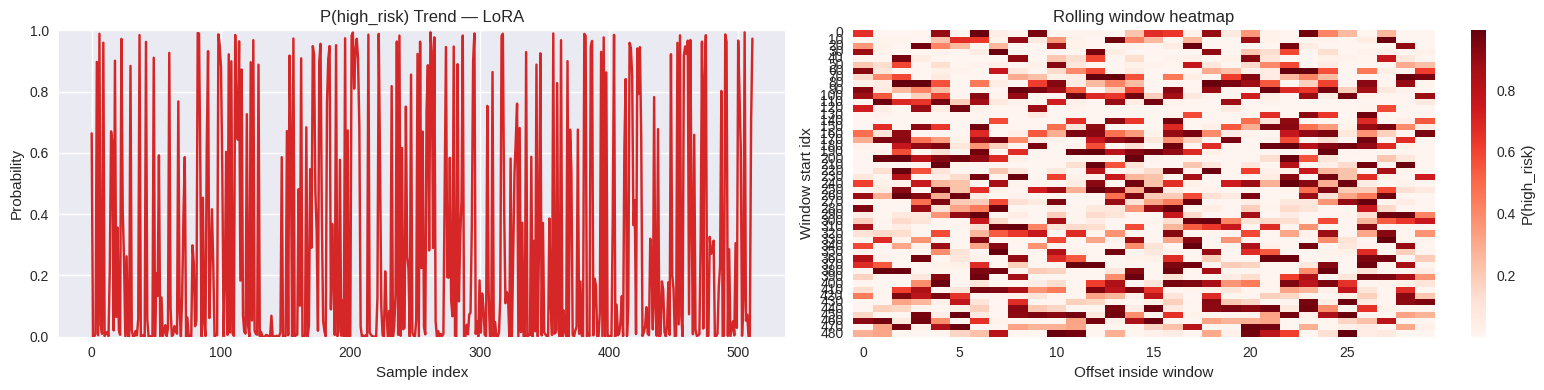

In [21]:
preferred_order = ["lora", "few_shot", "zero_shot"]
active_key = next((k for k in preferred_order if k in experiments), None)
if active_key is None:
    raise ValueError("No available experiments for visualization.")
vis_df = experiments[active_key]["records"].copy()
vis_limit = min(CONFIG["max_eval_examples_for_visualization"], len(vis_df))
vis_df = vis_df.head(vis_limit)
vis_df["high_risk_prob"] = vis_df["risk_probs"].apply(lambda probs: probs[2])
high_risk_series = vis_df["high_risk_prob"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(high_risk_series, color="#d62728")
axes[0].set_title(f"P(high_risk) Trend — {method_display.get(active_key, active_key)}")
axes[0].set_xlabel("Sample index")
axes[0].set_ylabel("Probability")
axes[0].set_ylim(0, 1)

window = CONFIG["rolling_window"]
stride = CONFIG["rolling_stride"]
heat_rows = []
labels = []
for start in range(0, len(high_risk_series) - window + 1, stride):
    window_slice = high_risk_series[start : start + window]
    heat_rows.append(window_slice)
    labels.append(start)
if heat_rows:
    heat = np.stack(heat_rows)
    sns.heatmap(
        heat,
        ax=axes[1],
        cmap="Reds",
        cbar_kws={"label": "P(high_risk)"},
        xticklabels=5,
        yticklabels=labels,
    )
    axes[1].set_title("Rolling window heatmap")
    axes[1].set_xlabel("Offset inside window")
    axes[1].set_ylabel("Window start idx")
else:
    axes[1].text(0.5, 0.5, "Not enough samples for rolling window", ha="center")
plt.tight_layout()
plt.show()

## 評估結果：表格＋圖形解讀
- `comparison_df` 彙整 Emotion 與 Risk 指標，可直接比較 Zero-shot / Few-shot / LoRA 於 Accuracy、Macro-F1、AUROC、PR-AUC、Confusion Matrix 的差異。
- 從表格可觀察 Few-shot 已優於 Zero-shot，而 LoRA 再次提升情緒與風險雙任務的 Macro-F1。
- 圖形部分使用最佳模型的 `P(high_risk)` 走勢與 rolling heatmap，協助分析何時出現高風險群聚、觀察連續樣本的風險濃度。
- 若需更深入比較，可對 `experiments` 字典中的逐筆 `emotion_probs`、`risk_probs` 做 ROC/PR 曲線或錯誤案例視覺化。


## 範例預測檢查
觀察最佳模型在部分樣本上的預測與高風險機率。

In [22]:
experiments[active_key]["records"][
    ["text", "emotion_true", "emotion_pred", "risk_true", "risk_pred", "high_risk_prob"]
].head(10)

,text,emotion_true,emotion_pred,risk_true,risk_pred,high_risk_prob
0,i was feeling really troubled and down over wh...,sadness,sadness,high_risk,high_risk,0.663718
1,i feel so thrilled to have three such distingu...,joy,joy,low_risk,low_risk,0.000053
2,i feel is that the most likeable characters ar...,joy,joy,low_risk,low_risk,0.001697
3,i tune out the rest of the world and focus on ...,joy,joy,low_risk,low_risk,0.008929
4,i sit here writing this i feel unhappy inside,sadness,sadness,high_risk,high_risk,0.896856
5,im feeling and if ive liked being pregnant,love,joy,low_risk,low_risk,0.004564
6,im very hurt and i feel unimportant,sadness,sadness,high_risk,high_risk,0.988697
7,i used to be able to hang around talk with the...,anger,anger,mid_risk,mid_risk,0.039520
8,i don t have the feeling of divine vibrations,joy,joy,low_risk,low_risk,0.009263
9,i vented my feelings towards the pathetic excu...,sadness,sadness,high_risk,high_risk,0.959514


## 技術報告摘要
- 執行完成後可由 `comparison_df` 直接讀取 Emotion / Risk 評估指標 (Accuracy、F1、AUROC、PR-AUC、Confusion Matrix)。
- `experiments` 字典保留各方法的逐筆預測，可用於誤差分析或製作更多視覺化。
- LoRA 訓練僅示範 1 epoch 與 4k 筆資料，建議在 GPU/TPU 上增加資料量與 epoch，以獲得更穩定的表現。
- 若資源允許，可嘗試更大的開源模型（LLaMA / Qwen / Mistral）或加入指標如 calibration / expected cost。
- 視覺化區塊可延伸為即時監測 dashboard，或以 rolling interval 對接真實世界時間戳記。

## 模型限制、偏差與潛在風險
- **資料偏差**：Emotion Dataset 為英文短句，風格偏向 Twitter/短訊語料，映射到憂鬱風險僅為 proxy，無法直接取代臨床診斷。
- **文化/語言限制**：模型以英文訓練，對於中文或其他語言輸入僅能依訓練語料泛化，易產生錯判。
- **風險映射假設**：單純將悲傷視為高風險可能忽略語境，例如諷刺或引用歌詞；anger/fear 亦未納入強度資訊。
- **模型幻覺**：Zero/Few-shot 依賴 prompt，若輸入含多重情緒或複雜語意，LLM 仍可能產生不一致輸出。
- **倫理與隱私**：部署於社群監測時需考量資料匿名化、告知機制與誤判對個人造成的後果，必要時應納入人工複核。
